In [1]:
import pandas as pd

path ="C:\\Users\\edugj\\PROGRAMACAO\\turing\\projetoTA\\dataset\\rede_americana\\PJM_Load_hourly.csv"
df = pd.read_csv(path)

In [2]:
df.head()

,Datetime,PJM_Load_MW
0,1998-12-31 01:00:00,29309.0
1,1998-12-31 02:00:00,28236.0
2,1998-12-31 03:00:00,27692.0
3,1998-12-31 04:00:00,27596.0
4,1998-12-31 05:00:00,27888.0


In [3]:
df.describe()

,PJM_Load_MW
count,32896.000000
mean,29766.427408
std,5849.769954
min,17461.000000
25%,25473.000000
50%,29655.000000
75%,33073.250000
max,54030.000000


In [4]:
df.tail()

,Datetime,PJM_Load_MW
32891,2001-01-01 20:00:00,35209.0
32892,2001-01-01 21:00:00,34791.0
32893,2001-01-01 22:00:00,33669.0
32894,2001-01-01 23:00:00,31809.0
32895,2001-01-02 00:00:00,29506.0


In [5]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

df.set_index('Datetime',inplace=True)

In [6]:
df

,PJM_Load_MW
Datetime,
1998-12-31 01:00:00,29309.0
1998-12-31 02:00:00,28236.0
1998-12-31 03:00:00,27692.0
1998-12-31 04:00:00,27596.0
1998-12-31 05:00:00,27888.0
...,...
2001-01-01 20:00:00,35209.0
2001-01-01 21:00:00,34791.0
2001-01-01 22:00:00,33669.0


<Axes: xlabel='Datetime'>

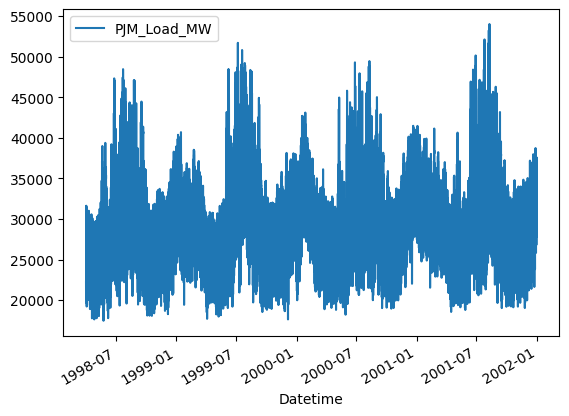

In [7]:
df.sort_index(inplace=True)
df.plot()

<Axes: xlabel='Datetime'>

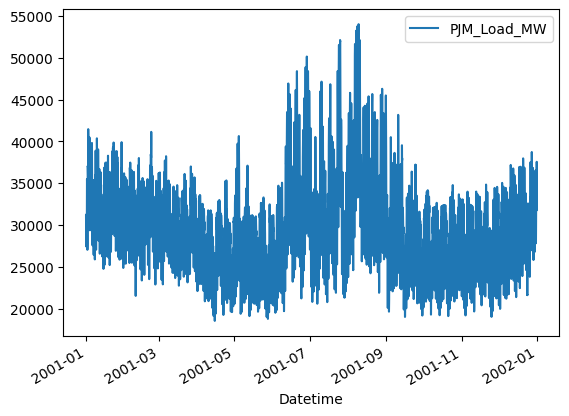

In [8]:
df[df.index.year == 2001].plot()

In [9]:
df2 = pd.read_csv("C:\\Users\\edugj\\PROGRAMACAO\\turing\\projetoTA\\dataset\\rede_americana\\DOM_hourly.csv")

df2['Datetime'] = pd.to_datetime(df2['Datetime'])

df2.set_index('Datetime', inplace= True)

df2.sort_index(inplace=True)

<Axes: xlabel='Datetime'>

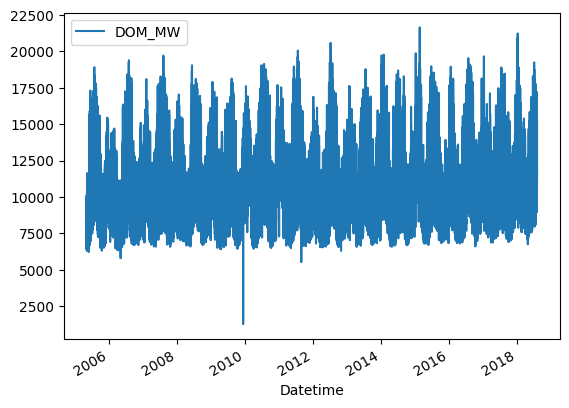

In [10]:
df2.plot()

In [11]:
df2.index.year.unique()

Index([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018],
      dtype='int32', name='Datetime')

<Axes: xlabel='Datetime'>

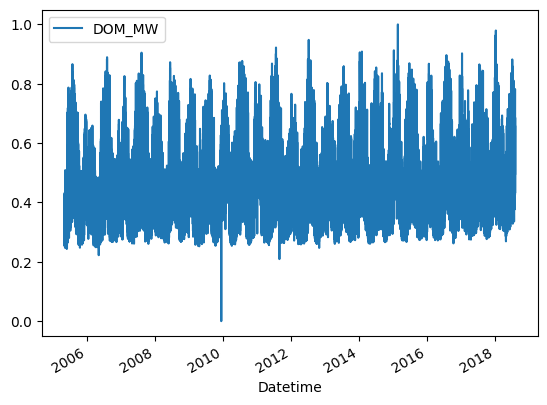

In [26]:
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

def normalize_data(df2):
    scaler = MinMaxScaler()
    dados_normalizados = scaler.fit_transform(df2['DOM_MW'].values.reshape(-1,1))
    df2['DOM_MW'] = dados_normalizados
    return df2, scaler


df_norm, scaler=normalize_data(df2)


df_norm.plot()

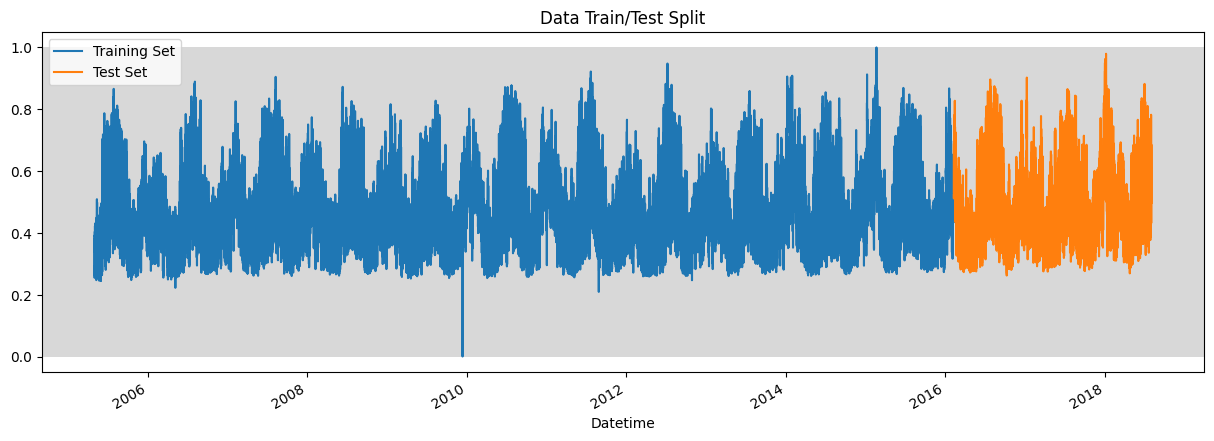

In [13]:
data_split = '2016-02-10'

train = df_norm.loc[df_norm.index < data_split].copy()
test = df_norm.loc[df_norm.index >= data_split].copy()

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)
plt.show()

Agora vamos treinar nosso MODELO NA MORAL

In [14]:
import torch
import numpy as np
import torch.nn as nn

In [15]:
def cria_janelas(data, tamanho):
    x = []
    y = []
    for i in range(tamanho, len(data)):
        x_aux=data.iloc[i-tamanho:i,0]
        y_aux=data.iloc[i,0]
        x.append(x_aux)
        y.append(y_aux)
    return np.array(x).astype(np.float32) , np.array(y).astype(np.float32)

train = df_norm.loc[df_norm.index < data_split].copy()
test = df_norm.loc[df_norm.index >= data_split].copy()

tamanho = 30


xtrain , ytrain = cria_janelas(train,tamanho)

xtest, ytest = cria_janelas(test, tamanho)

trainX = torch.tensor(xtrain[:,:,None], dtype=torch.float32)
trainY = torch.tensor(ytrain[:,None], dtype=torch.float32)

testX = torch.tensor(xtest[:,:,None], dtype=torch.float32)
testY = torch.tensor(ytest[:,None], dtype=torch.float32)






In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc   = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)          
        out = self.fc(out[:, -1, :])   
        return out 

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size     = 64
num_epochs     = 30
hidden_dim     = 64
learning_rate  = 1e-3
device         = 'cuda' if torch.cuda.is_available() else 'cpu'

train_ds = TensorDataset(trainX, trainY)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)

model = LSTMModel(1, hidden_dim, 1, 1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0.0

    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * xb.size(0)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:03d} | loss={epoch_loss/len(train_ds):.5f}')


Epoch 010 | loss=0.00011
Epoch 020 | loss=0.00007
Epoch 030 | loss=0.00006
Epoch 040 | loss=0.00005
Epoch 050 | loss=0.00005
Epoch 060 | loss=0.00005


KeyboardInterrupt: 

In [24]:
torch.save(model.state_dict(), "lstm_temp.pth")


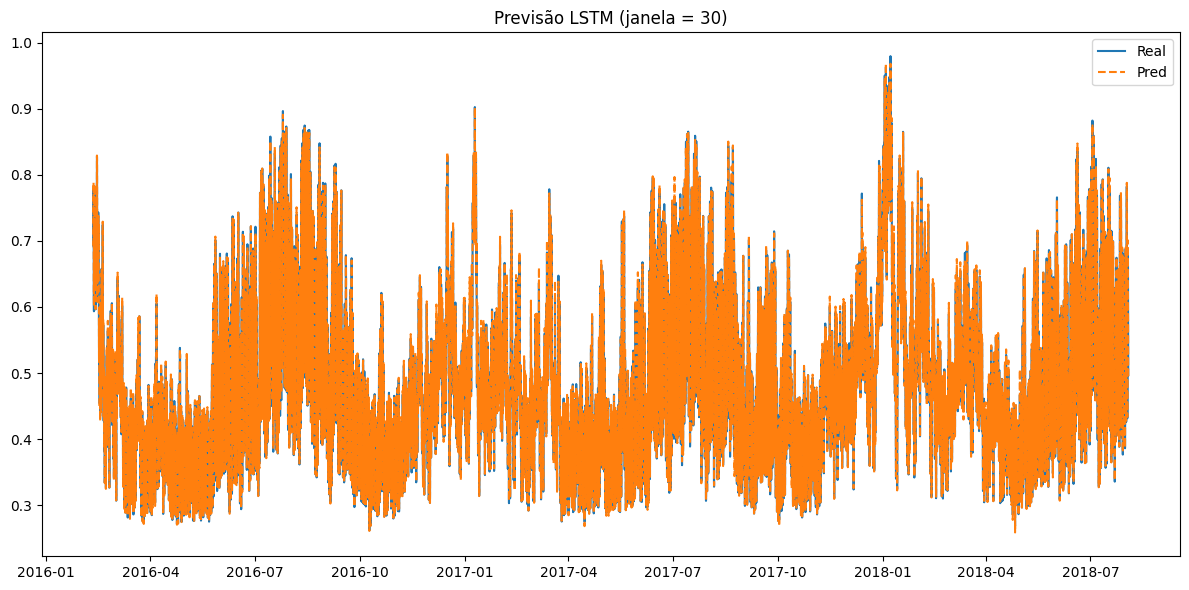

In [ ]:
model.eval()
with torch.no_grad():
    pred_test = model(testX.to(device)).cpu().numpy()   
pred_test_inv = scaler.inverse_transform(pred_test)
testY_inv     = scaler.inverse_transform(testY.numpy())

plt.figure(figsize=(12, 6))
plt.plot(test.index[tamanho:],  testY_inv.ravel(), label='Real')
plt.plot(test.index[tamanho:],  pred_test_inv.ravel(), '--', label='Pred')
plt.title('Previsão LSTM (janela = 30)')
plt.legend()
plt.tight_layout()
plt.show()
